In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os


import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Path_Energy = 'PJME_hourly.csv'
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])
data = data.sort_index()
data.index = pd.to_datetime(data.index.astype('str')+' '+data['Time'].astype('str'))
data.sort_index(inplace=True)
data.drop('Time',axis=1, inplace =True)
data.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
2002-01-01 01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01 02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01 03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01 04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01 05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


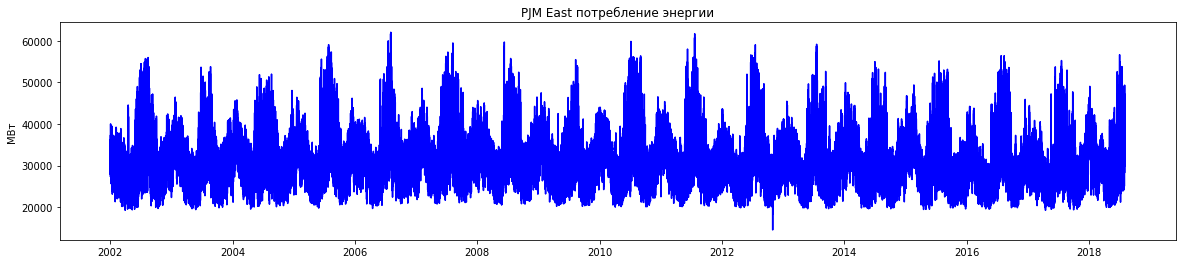

In [3]:
data['data_time']=data.index
plt.figure(figsize =(20,4))
plt.plot( data.index, data['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

In [4]:
#Разберём ряд на вектора и определим параметры распределения

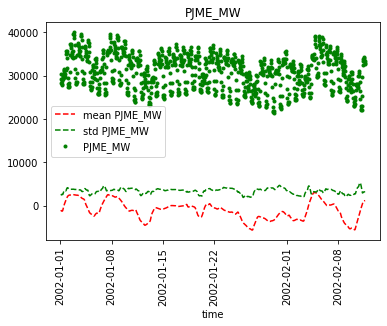

In [5]:
#размер окна  (в часах)
w = 24
#шаг окна  (в часах)
step_w= 1
mean_d=[]
std_d=[]

MeanT=np.mean(data['PJME_MW'])

for i in range(1000):
    d = data['PJME_MW'].iloc[i:i+w] - MeanT
    mean_d.append(np.mean(d))
    std_d.append(np.std(d))
plt.plot(data['data_time'].iloc[:1000],mean_d,'--r',label='mean PJME_MW')    
plt.plot(data['data_time'].iloc[:1000],std_d,'--g',label='std PJME_MW') 
plt.plot(data['data_time'].iloc[:1000],data['PJME_MW'].iloc[:1000],'.g',label='PJME_MW')
plt.title('PJME_MW')
plt.legend()
plt.xlabel('time')
plt.xticks(rotation='90')
plt.show()

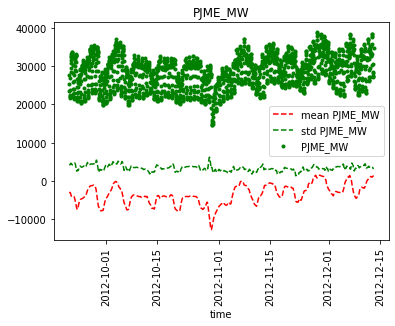

In [6]:


#размер окна  (в часах)
w = 24

#шаг окна  (в часах)
step_w= 1

T=24*365*11-24*100
mean_da=[]
std_da=[]
for i in range(2000):
    da = data['PJME_MW'].iloc[T+i:T+i+w] - MeanT
    mean_da.append(np.mean(da))
    std_da.append(np.std(da))
std_da = np.array(std_da)
plt.plot(data['data_time'].iloc[T:2000+T],mean_da,'--r',label='mean PJME_MW')    
plt.plot(data['data_time'].iloc[T:2000+T],std_da,'--g',label='std PJME_MW') 
plt.plot(data['data_time'].iloc[T:2000+T],data['PJME_MW'].iloc[T:2000+T],'.g',label='PJME_MW')
plt.title('PJME_MW')
plt.xlabel('time')
plt.legend()
plt.xticks(rotation='90')
plt.show()



In [7]:
#Скользящее окно. Сделаем сглаживание по среднему на дневыные интервалы и месячные циклы

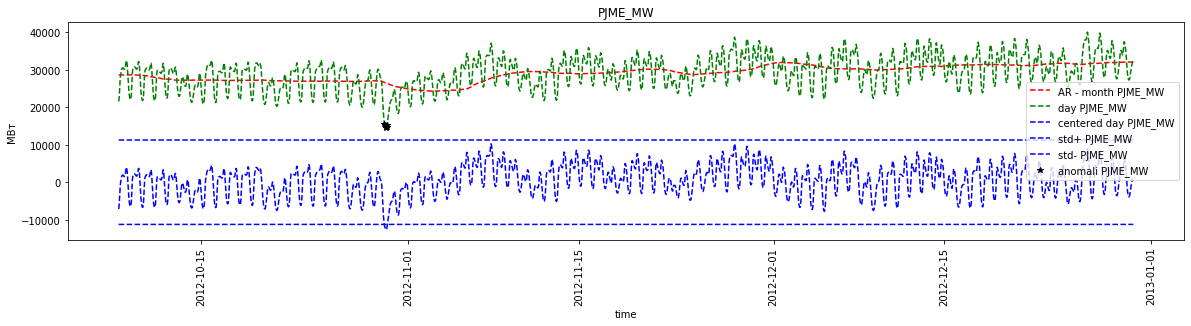

In [8]:
#размер окна  (в часах)
w = 24
#шаг окна  (в часах)
step_w= 1

data_m=data['PJME_MW'].rolling(w*30).mean()
diff_day = data['PJME_MW'].rolling(2).mean()#-data_m
data_d=data['PJME_MW'].rolling(w*7).mean()
#data_d[np.where(np.abs(data_d)<0.0001)[0]]=data_d.mean()
diff_day_month=diff_day-data_m
sigma3_diff_day_month = diff_day_month.std()*2

porog_ = np.abs(diff_day_month[-51000:-49000]) > sigma3_diff_day_month 
ind_ = np.where(porog_==1)[0]

plt.figure(figsize =(20,4))
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.plot(data['data_time'].iloc[-51000:-49000],data_d[-51000:-49000],'--r',label='AR - month PJME_MW')
plt.plot(data['data_time'].iloc[-51000:-49000],diff_day[-51000:-49000],'--g',label='day PJME_MW')
plt.plot(data['data_time'].iloc[-51000:-49000],diff_day_month[-51000:-49000],'--b',label='centered day PJME_MW')
plt.plot(data['data_time'].iloc[-51000:-49000],[-sigma3_diff_day_month]*2000 ,'--b',label='std+ PJME_MW')

plt.plot(data['data_time'].iloc[-51000:-49000],[sigma3_diff_day_month]*2000 ,'--b',label='std- PJME_MW')
plt.plot(data['data_time'].iloc[-51000:-49000].values[ind_],diff_day[-51000:-49000].values[ind_],'*k',label='anomali PJME_MW') 

plt.title('PJME_MW')
plt.xlabel('time')
plt.legend()
plt.xticks(rotation='90')
plt.show()

In [9]:
#Кластеризация. Добавим ряду первые разности в набор данных и сделаем историческое оисание

In [10]:
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

scl=StandardScaler()

from sklearn.cluster import KMeans, DBSCAN

In [11]:
data['stat'] = diff_day_month

p =3

#добавляем историю длиной р
for i in range(p):
    data['t'+str(p-i+1)]=0
    data['t'+str(p-i+1)].values[p+2:] = data['PJME_MW'].values[i+1:-(p-i+1)]
for i in range(p):
    data['d'+str(p-i+1)]=0    
    data['d'+str(p-i+1)].values[i+1:] = (data['PJME_MW'].values[i+1:]- data['PJME_MW'].values[i:-1])/data['PJME_MW'].values[i:-1]
data.head(10)

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday,data_time,stat,t4,t3,t2,d4,d3,d2
2002-01-01 01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0,2002-01-01 01:00:00,NaN,0,0,0,0,0,0
2002-01-01 02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0,2002-01-01 02:00:00,NaN,0,0,0,0,0,0
2002-01-01 03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0,2002-01-01 03:00:00,NaN,0,0,0,0,0,0
2002-01-01 04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0,2002-01-01 04:00:00,NaN,0,0,0,0,0,0
2002-01-01 05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0,2002-01-01 05:00:00,NaN,0,0,0,0,0,0
2002-01-01 06:00:00,28654.0,2002,1,1,1,1,1,1,6,1,0,0,2002-01-01 06:00:00,NaN,29265,28357,27899,0,0,0
2002-01-01 07:00:00,29308.0,2002,1,1,1,1,1,1,7,1,0,0,2002-01-01 07:00:00,NaN,28357,27899,28057,0,0,0
2002-01-01 08:00:00,29595.0,2002,1,1,1,1,1,1,8,1,0,0,2002-01-01 08:00:00,NaN,27899,28057,28654,0,0,0
2002-01-01 09:00:00,29943.0,2002,1,1,1,1,1,1,9,1,0,0,2002-01-01 09:00:00,NaN,28057,28654,29308,0,0,0
2002-01-01 10:00:00,30692.0,2002,1,1,1,1,1,1,10,1,0,0,2002-01-01 10:00:00,NaN,28654,29308,29595,0,0,0


In [12]:
X = data.drop(['data_time'],axis=1).iloc[p+2:,1:].values

In [13]:
Xscale = scl.fit_transform(X[-51000:-49000,:])

clast = DBSCAN(eps=1.0, leaf_size=5, min_samples = 3)
X_scale_clast =clast.fit_predict(Xscale)

первый элемент кластера 0  :  [ 0.         -1.34142074 -1.02932223  0.         -1.71979668 -1.59870342
 -1.50304942 -0.79509168  4.58017707 -0.19324699 -0.22454436 -1.67785329
 -1.76512351 -1.86448388 -1.85858705  0.          0.          0.        ]
Число кластеров с масштабированием:  19
Число не кластеров:  7


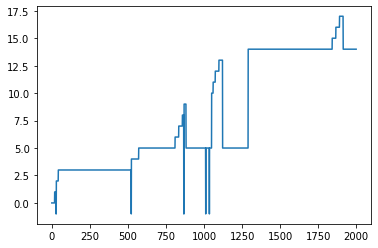

In [14]:
# не шум, но кластер со смыслом
ind_c= np.where(X_scale_clast !=-1)[0]
print('первый элемент кластера',X_scale_clast[ind_c[0]],' : ',clast.components_[0])
print('Число кластеров с масштабированием: ',len(np.unique(X_scale_clast)-1))

n_noise = list(clast.labels_).count(-1)

print('Число не кластеров: ',n_noise)

plt.plot(X_scale_clast)
plt.show()

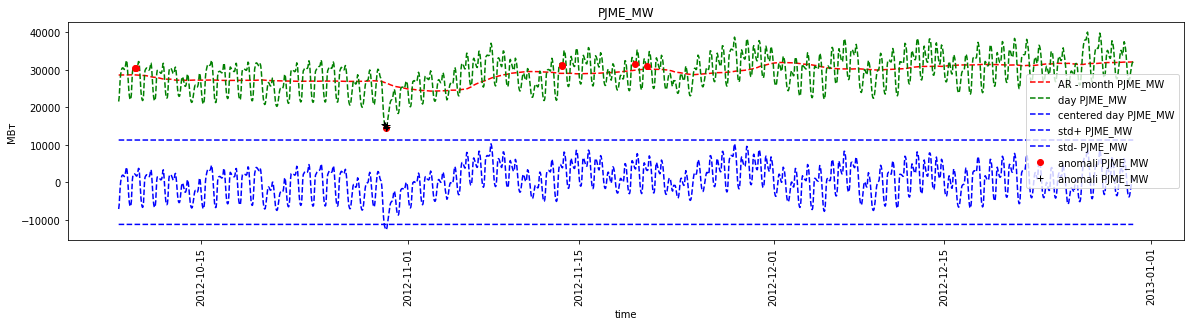

In [15]:


ind_anomal_c= np.where(X_scale_clast ==-1)[0]  # индексы аномалий (наверное аномалий - будем смотреть)

ind_anomal_c = np.array(ind_anomal_c)+p+2  


plt.figure(figsize =(20,4))
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.plot(data['data_time'].iloc[-51000:-49000],data_d[-51000:-49000],'--r',label='AR - month PJME_MW')
plt.plot(data['data_time'].iloc[-51000:-49000],diff_day[-51000:-49000],'--g',label='day PJME_MW')
plt.plot(data['data_time'].iloc[-51000:-49000],diff_day_month[-51000:-49000],'--b',label='centered day PJME_MW')
plt.plot(data['data_time'].iloc[-51000:-49000],[-sigma3_diff_day_month]*2000 ,'--b',label='std+ PJME_MW')

plt.plot(data['data_time'].iloc[-51000:-49000],[sigma3_diff_day_month]*2000 ,'--b',label='std- PJME_MW')
plt.plot(data['data_time'].iloc[-51000:-49000].values[ind_anomal_c],diff_day[-51000:-49000].values[ind_anomal_c],'or',label='anomali PJME_MW') 
plt.plot(data['data_time'].iloc[-51000:-49000].values[ind_],diff_day[-51000:-49000].values[ind_],'+k',label='anomali PJME_MW') 

plt.title('PJME_MW')
plt.xlabel('time')
plt.legend()
plt.xticks(rotation='90')
plt.show()



In [16]:
data_week=data['PJME_MW'].resample("W").apply('mean')

np.where(data_week.index.weekofyear == pd.to_datetime('2012-10-30').weekofyear)[0]

array([ 43,  95, 147, 200, 252, 304, 356, 408, 461, 513, 565, 617, 669,
       721, 774, 826])

In [17]:
data_month=data['PJME_MW'].resample("M").apply('mean')
len(data_month)

200

In [18]:
mod = sm.tsa.statespace.SARIMAX(data_week.values[200:560],order=[0,0,0],
                                seasonal_order=[2,0,0,52] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print('AIC:{}',results_opt.aic)

AIC:{} 4722.690984524124


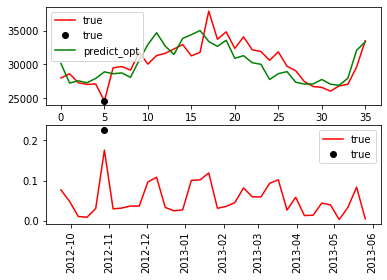

In [19]:
pred_dynamic_opt = results_opt.forecast(12*3)
plt.subplot(2,1,1)
plt.plot( data_week.values[560:560+12*3], 'r',label='true' )
plt.plot( 5,data_week.values[565], 'ok',label='true' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
plt.legend()
plt.subplot(2,1,2)

plt.plot( data_week.index[560-1:560+12*3-1],np.abs(data_week.values[560:560+12*3]-pred_dynamic_opt)/data_week.values[560:560+12*3], 'r',label='true' )
plt.plot( data_week.index[565-1],np.abs(data_week.values[565]-pred_dynamic_opt[0])/data_week.values[565], 'ok',label='true' )
plt.xticks(rotation='90')
plt.legend()
plt.show()

# Прочитайте базу my_BRENT2019.csv

In [20]:
path_brent = 'my_BRENT2019.csv'
brent_data = pd.read_csv(path_brent,sep = ',', index_col=[0], parse_dates=[0])
brent_data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


In [21]:
brent_data.isnull()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,False,False,False,False,False,False,False,False,False,False,False
2010-09-02,False,False,False,False,False,False,False,False,False,False,False
2010-09-03,False,False,False,False,False,False,False,False,False,False,False
2010-09-04,False,False,False,False,False,False,False,False,False,False,False
2010-09-05,False,False,False,False,False,False,False,False,False,False,False
2010-09-06,False,False,False,False,False,False,False,False,False,False,False
2010-09-07,False,False,False,False,False,False,False,False,False,False,False
2010-09-08,False,False,False,False,False,False,False,False,False,False,False
2010-09-09,False,False,False,False,False,False,False,False,False,False,False


Text(0.5, 0, 't')

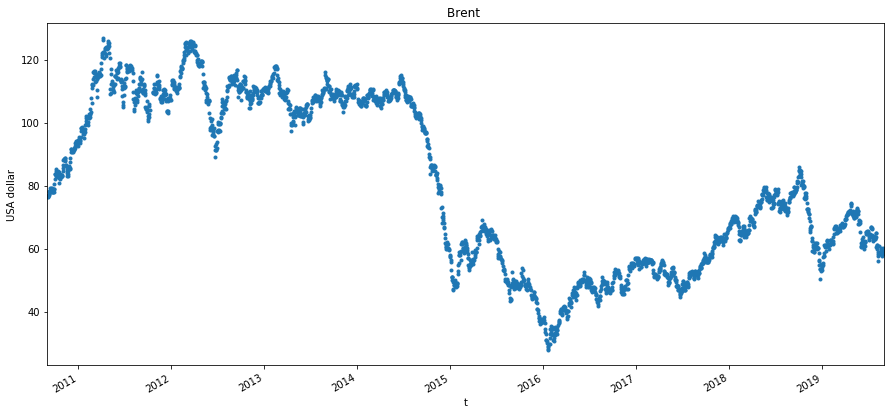

In [22]:
_ = brent_data['Значение'].plot( style='.', figsize=( 15, 7 ), title='Brent ')
plt.ylabel('USA dollar')
plt.xlabel('t')

## Перейдите к представлению её первыми разностями

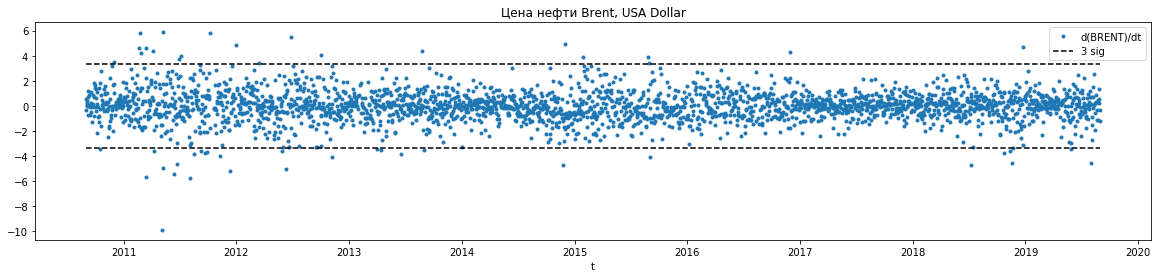

In [23]:
d_brent_data = brent_data['Значение'].values[1:]- brent_data['Значение'].values[:-1]
s_brent = np.std(d_brent_data)**0.5 *3
plt.figure(figsize=(20,4))
plt.plot(brent_data.iloc[:-1].index,d_brent_data,'.', label='d(BRENT)/dt')
plt.plot(brent_data.iloc[[0,-1]].index,[s_brent, s_brent],'--k',label ='3 sig')
plt.plot(brent_data.iloc[[0,-1]].index,[-s_brent, -s_brent],'--k')
plt.xlabel('t')
plt.legend()
plt.title('Цена нефти Brent, USA Dollar')
plt.show()

ind_anomal_brent = np.where( abs(d_brent_data)>s_brent)[0]

Text(0.5, 0, 't')

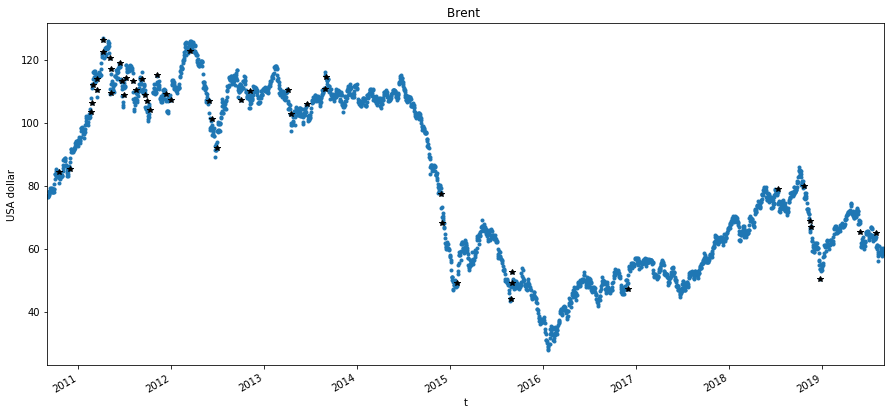

In [24]:
_ = brent_data['Значение'].plot( style='.', figsize=( 15, 7 ), title='Brent ')
plt.plot(brent_data.iloc[ind_anomal_brent].index,brent_data['Значение'].values[ind_anomal_brent],'*k', label='BRENT anomaly')
plt.ylabel('USA dollar')
plt.xlabel('t')

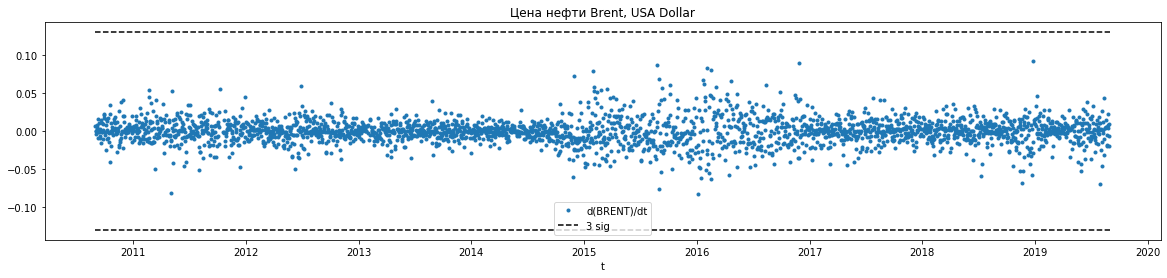

In [25]:
d_brent_data1 = (brent_data['Значение'].values[1:]- brent_data['Значение'].values[:-1])/brent_data['Значение'].values[:-1]

s_brent1 = np.std(d_brent_data1)**0.5 
plt.figure(figsize=(20,4))
plt.plot(brent_data.iloc[:-1].index,d_brent_data1,'.', label='d(BRENT)/dt')
plt.plot(brent_data.iloc[[0,-1]].index,[s_brent1, s_brent1],'--k',label ='3 sig')
plt.plot(brent_data.iloc[[0,-1]].index,[-s_brent1, -s_brent1],'--k')
plt.xlabel('t')
plt.legend()
plt.title('Цена нефти Brent, USA Dollar')
plt.show()

ind_anomal_brent1 = np.where( abs(d_brent_data1)>s_brent1)[0]

In [26]:
brent_data.index[[0,-1]]

DatetimeIndex(['2010-09-01', '2019-09-01'], dtype='datetime64[ns]', name='Дата', freq=None)

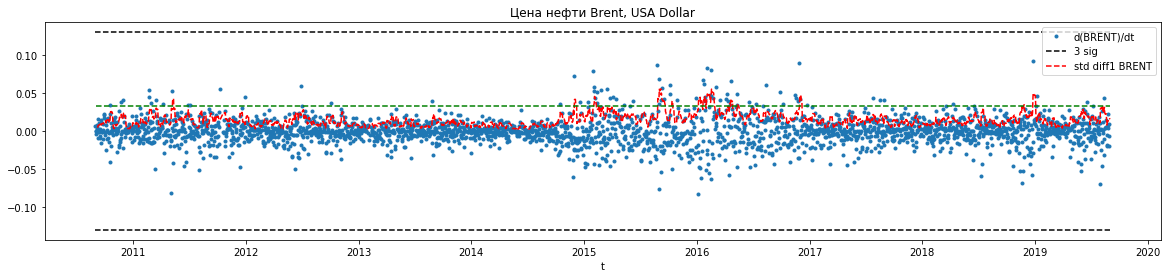

In [27]:
brent_diff1=pd.DataFrame(data=d_brent_data1, index=brent_data.index[1:])

brent_diff1_std=brent_diff1[0].rolling(7).std()
brent_diff_std=np.std(brent_diff1_std)*4

ind_anomal_brent2 = np.where( abs(brent_diff1_std)>brent_diff_std)[0]

plt.figure(figsize=(20,4))
plt.plot(brent_data.iloc[:-1].index,d_brent_data1,'.', label='d(BRENT)/dt')
plt.plot(brent_data.iloc[[0,-1]].index,[s_brent1, s_brent1],'--k',label ='3 sig')
plt.plot(brent_data.iloc[[0,-1]].index,[-s_brent1, -s_brent1],'--k')
plt.plot(brent_diff1_std,'--r',label ='std diff1 BRENT')
plt.plot(brent_diff1_std.iloc[[0,-1]].index,[brent_diff_std,brent_diff_std],'--g')
plt.xlabel('t')
plt.legend()
plt.title('Цена нефти Brent, USA Dollar')
plt.show()

In [28]:


brent_diff_std



0.0337053481460818

In [29]:
p =3

#добавляем историю длиной р
for i in range(p):
    brent_data['t'+str(p-i+1)]=0
    brent_data['t'+str(p-i+1)].values[p+2:] = brent_data['Значение'].values[i+1:-(p-i+1)]
for i in range(p):
    brent_data['d'+str(p-i+1)]=0    
    brent_data['d'+str(p-i+1)].values[i+1:] =( (brent_data['Значение'].values[i+1:]- brent_data['Значение'].values[i:-1]))

In [30]:
X = brent_data.iloc[p+2:,:].values

Xscale = scl.fit_transform(X)

clast = DBSCAN(eps=2.9, leaf_size=1, min_samples = 3)
X_scale_clast =clast.fit_predict(Xscale)

первый элемент кластера 0  :  [-0.17721153 -1.75698575  0.72500659 -1.11065221  0.44539858  0.63193593
  0.63776124 -1.33798808  5.91379514 -0.16553715 -0.17488451 -0.19246036
 -0.19219421 -0.19194461  0.00947192  0.00947192  0.00947192]
Число кластеров с масштабированием:  8
Число не кластеров:  20


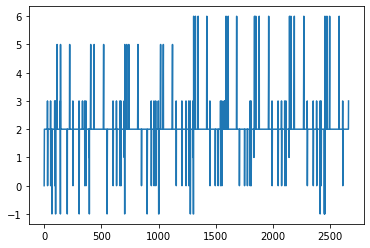

In [31]:
# не шум, но кластер со смыслом
ind_= np.where(X_scale_clast !=-1)[0]
print('первый элемент кластера',X_scale_clast[ind_[0]],' : ',clast.components_[0])
print('Число кластеров с масштабированием: ',len(np.unique(X_scale_clast)-1))

n_noise = list(clast.labels_).count(-1)

print('Число не кластеров: ',n_noise)

plt.plot(X_scale_clast)
plt.show()

Text(0.5, 0, 't')

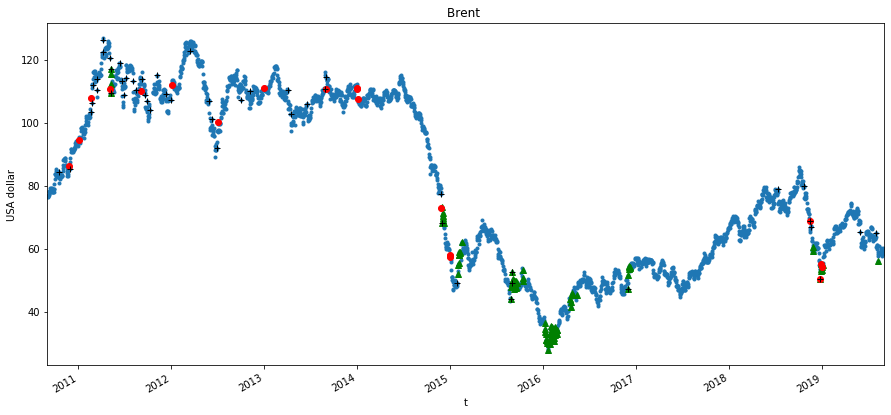

In [32]:
ind_anomal_brent_c= np.where(X_scale_clast ==-1)[0]  # индексы аномалий (наверное аномалий - будем смотреть)

ind_anomal_brent_c = np.array(ind_anomal_brent_c)+p+2  

_ = brent_data['Значение'].plot( style='.', figsize=( 15, 7 ), title='Brent ')
plt.plot(brent_data.iloc[ind_anomal_brent2].index,brent_data['Значение'].values[ind_anomal_brent2],'^g', label='BRENT anomaly stat')
plt.plot(brent_data.iloc[ind_anomal_brent_c].index,brent_data['Значение'].values[ind_anomal_brent_c],'or', label='BRENT anomaly claster')
plt.plot(brent_data.iloc[ind_anomal_brent].index,brent_data['Значение'].values[ind_anomal_brent],'+k', label='BRENT anomaly stat')

plt.ylabel('USA dollar')
plt.xlabel('t')

# Добавьте первые разности по стоимости доллара и евро к рублю

In [33]:
rub_doll=pd.read_excel('RC_F01_09_2010_T01_09_2019.xlsx')
rub_doll.index = pd.to_datetime(rub_doll['data'].values).date
rub_doll.drop(['nominal','cdx','data'], axis=1,inplace = True)
rub_doll.head()

,curs
2010-09-01,30.8669
2010-09-02,30.8001
2010-09-03,30.6858
2010-09-04,30.6922
2010-09-07,30.5771


## Первая разность по рублю к доллару

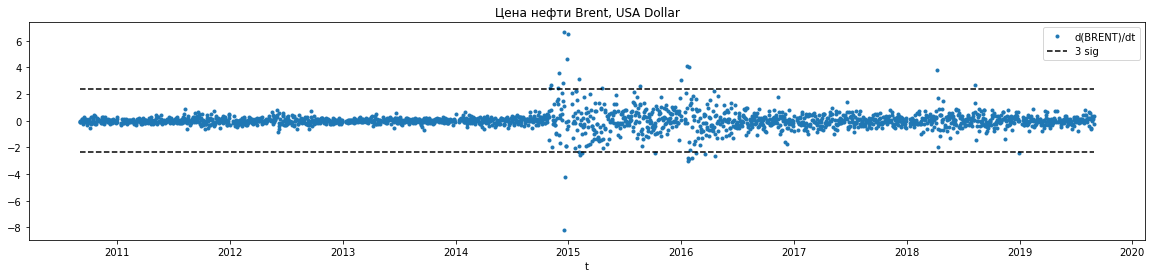

In [34]:
d_rub_doll_diff1 = rub_doll['curs'].values[1:]- rub_doll['curs'].values[:-1]
s_rub_doll = np.std(d_rub_doll_diff1)**0.5 *3

plt.figure(figsize=(20,4))
plt.plot(rub_doll.iloc[:-1].index,d_rub_doll_diff1,'.', label='d(BRENT)/dt')
plt.plot(rub_doll.iloc[[0,-1]].index,[s_rub_doll, s_rub_doll],'--k',label ='3 sig')
plt.plot(rub_doll.iloc[[0,-1]].index,[-s_rub_doll, -s_rub_doll],'--k')
plt.xlabel('t')
plt.legend()
plt.title('Цена нефти Brent, USA Dollar')
plt.show()

ind_anomal_rub_doll = np.where( abs(d_rub_doll_diff1)>s_rub_doll)[0]



## Первая разность по рублю к евро

In [35]:
rub_e=pd.read_excel('R_E01_09_2010_T01_09_2019.xlsx')
rub_e.index = pd.to_datetime(rub_e['data'].values).date
rub_e.drop(['nominal','cdx','data'], axis=1,inplace = True)
rub_e.head()

,curs
2010-09-01,39.0127
2010-09-02,39.1654
2010-09-03,39.2901
2010-09-04,39.3505
2010-09-07,39.4720


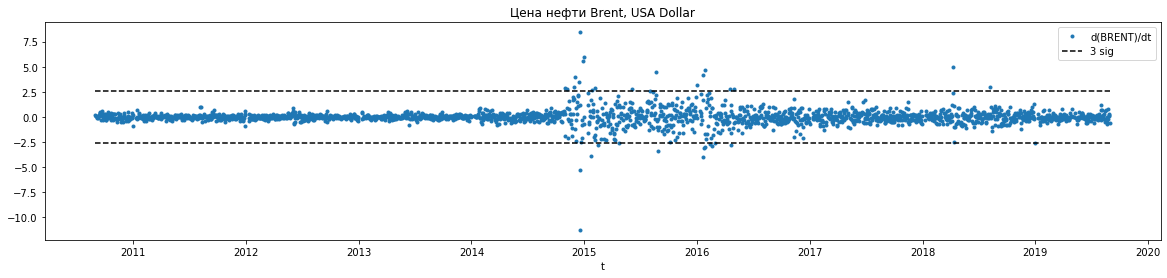

In [36]:
d_rub_e_diff1 = rub_e['curs'].values[1:]- rub_e['curs'].values[:-1]
s_rub_e = np.std(d_rub_e_diff1)**0.5 *3

plt.figure(figsize=(20,4))
plt.plot(rub_e.iloc[:-1].index,d_rub_e_diff1,'.', label='d(BRENT)/dt')
plt.plot(rub_e.iloc[[0,-1]].index,[s_rub_e, s_rub_e],'--k',label ='3 sig')
plt.plot(rub_e.iloc[[0,-1]].index,[-s_rub_e, -s_rub_e],'--k')
plt.xlabel('t')
plt.legend()
plt.title('Цена нефти Brent, USA Dollar')
plt.show()

ind_anomal_rub_e = np.where( abs(d_rub_e_diff1)>s_rub_e)[0]


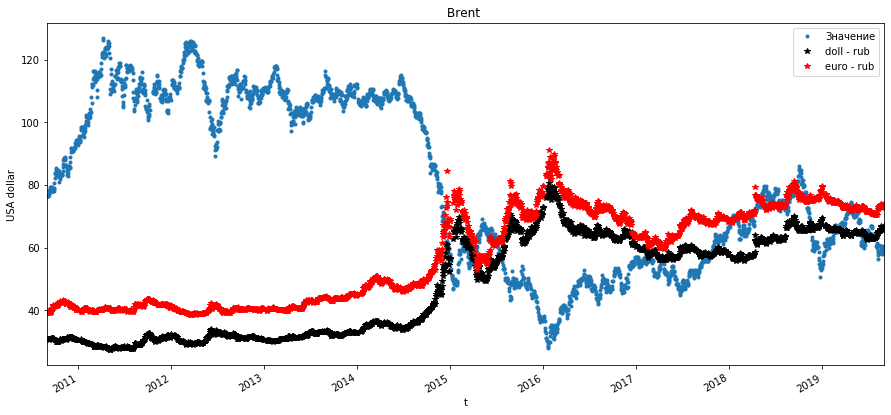

In [37]:
_ = brent_data['Значение'].plot( style='.', figsize=( 15, 7 ), title='Brent ')
plt.plot(rub_doll.index,rub_doll['curs'].values,'*k', label='doll - rub')
plt.plot(rub_e.index,rub_e['curs'].values,'*r', label='euro - rub')
plt.ylabel('USA dollar')
plt.xlabel('t')
plt.legend()
plt.show()

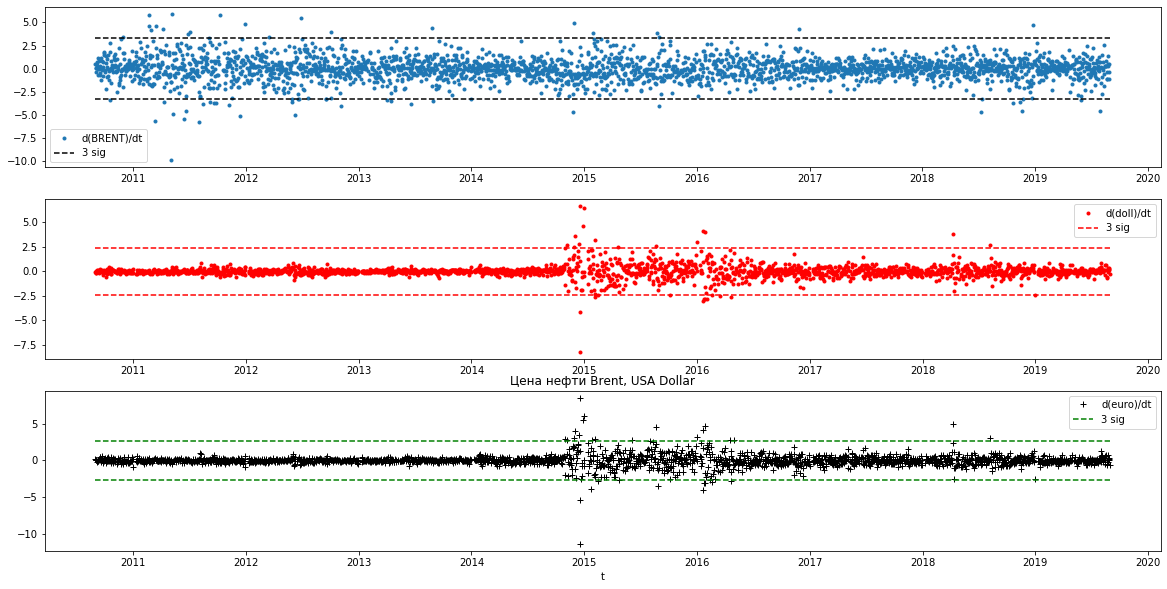

In [38]:
d_rub_doll = rub_doll['curs'].values[1:]- rub_doll['curs'].values[:-1]
s_rub = np.std(d_rub_doll)**0.5 *3

d_rub_e = rub_e['curs'].values[1:]- rub_e['curs'].values[:-1]
s_rube = np.std(d_rub_e)**0.5 *3

plt.figure(figsize=(20,10))
plt.subplot(3,1,1)
plt.plot(brent_data.iloc[:-1].index,d_brent_data,'.', label='d(BRENT)/dt')
plt.plot(brent_data.iloc[[0,-1]].index,[s_brent, s_brent],'--k',label ='3 sig')
plt.plot(brent_data.iloc[[0,-1]].index,[-s_brent, -s_brent],'--k')
plt.legend()

plt.subplot(3,1,2)
plt.plot(rub_doll.iloc[:-1].index,d_rub_doll,'.r', label='d(doll)/dt')
plt.plot(rub_doll.iloc[[0,-1]].index,[s_rub, s_rub],'--r',label ='3 sig')
plt.plot(rub_doll.iloc[[0,-1]].index,[-s_rub, -s_rub],'--r')
plt.legend()

plt.subplot(3,1,3)
plt.plot(rub_e.iloc[:-1].index,d_rub_e,'+k', label='d(euro)/dt')
plt.plot(rub_e.iloc[[0,-1]].index,[s_rube, s_rube],'--g',label ='3 sig')
plt.plot(rub_e.iloc[[0,-1]].index,[-s_rube, -s_rube],'--g')

plt.xlabel('t')
plt.legend()
plt.title('Цена нефти Brent, USA Dollar')
plt.show()

ind_anomal_brent = np.where( abs(d_brent_data)>s_brent)[0]
ind_anomal_rubl_d = np.where( abs(d_rub_doll)>s_rub)[0]
ind_anomal_rubl_e = np.where( abs(d_rub_e)>s_rube)[0]

In [39]:
ind_anomal_brent

array([  41,   78,  146,  148,  153,  164,  166,  184,  186,  206,  209,
        211,  240,  247,  252,  259,  283,  295,  314,  325,  330,  340,
        357,  386,  399,  462,  525,  535,  551,  634,  663,  777,  787,
        844,  900,  904, 1282, 1285, 1335, 1494, 1496, 1497, 1818, 2311,
       2400, 2418, 2424, 2454, 2586, 2639])

In [40]:
ind_anomal_rubl_d

array([1037, 1039, 1055, 1057, 1066, 1067, 1068, 1070, 1075, 1078, 1096,
       1097, 1103, 1147, 1232, 1264, 1325, 1333, 1334, 1335, 1336, 1337,
       1343, 1353, 1370, 1393, 1881, 1964, 2066])

In [41]:
ind_anomal_rubl_e

array([1037, 1039, 1055, 1057, 1066, 1067, 1068, 1070, 1075, 1078, 1087,
       1089, 1096, 1103, 1149, 1176, 1232, 1235, 1325, 1333, 1334, 1335,
       1336, 1337, 1350, 1353, 1392, 1393, 1402, 1881, 1964])

In [42]:
rub_doll.index[[1333, 1334, 1335, 1336, 1337]]

Index([2016-01-21, 2016-01-22, 2016-01-23, 2016-01-26, 2016-01-27], dtype='object')

In [43]:
brent_data['doll']=0
brent_data['doll'].values[1:2229]=rub_doll['curs'].values[:]
brent_data=brent_data.iloc[:2229,:]

In [44]:
brent_data.iloc[100:115,:]

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,t4,t3,t2,d4,d3,d2,doll
Дата,,,,,,,,,,,,,,,,,,
2010-12-27,93.71,2010,12,27,4,361,52,0,0,0,0,93,94,93,0,0,0,29
2010-12-28,94.21,2010,12,28,4,362,52,1,0,0,0,94,93,93,0,0,0,29
2010-12-29,94.03,2010,12,29,4,363,52,2,0,0,0,93,93,93,0,0,0,29
2010-12-30,92.71,2010,12,30,4,364,52,3,0,1,0,93,93,94,-1,-1,-1,29
2010-12-31,94.59,2010,12,31,4,365,52,4,1,0,0,93,94,94,1,1,1,29
2011-01-02,94.56,2011,1,2,1,2,52,6,0,0,0,94,94,92,0,0,0,29
2011-01-03,94.85,2011,1,3,1,3,1,0,0,0,0,94,92,94,0,0,0,29
2011-01-05,95.54,2011,1,5,1,5,1,2,0,0,0,92,94,94,0,0,0,29
2011-01-06,94.43,2011,1,6,1,6,1,3,0,0,0,94,94,94,-1,-1,-1,29


In [45]:
scl_target=StandardScaler() 

h=1
target = brent_data["Значение"].values[h:].reshape((brent_data.shape[0]-h,1))
y = scl_target.fit_transform(target)
y.shape

(2228, 1)

In [46]:
scl_x=StandardScaler() 

X = brent_data.iloc[:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

(2228, 18)

In [121]:
# df[df['name column'].isnull()]

In [47]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import f_regression, mutual_info_regression

f_test, _ = f_regression(X, y.ravel())

for i in range(X.shape[1]):
    print("F-test={:.2f},  I={}".format(f_test[i],i))

F-test=1107279.65,  I=0
F-test=3410.44,  I=1
F-test=0.58,  I=2
F-test=0.12,  I=3
F-test=0.44,  I=4
F-test=0.57,  I=5
F-test=0.56,  I=6
F-test=14.25,  I=7
F-test=0.29,  I=8
F-test=0.65,  I=9
F-test=0.23,  I=10
F-test=86245.01,  I=11
F-test=92446.32,  I=12
F-test=100202.39,  I=13
F-test=0.74,  I=14
F-test=0.74,  I=15
F-test=0.74,  I=16
F-test=3671.78,  I=17


In [48]:
sfk =SelectKBest(f_regression, k=5)
X_new1 =sfk.fit_transform(X, y.ravel())
X_new1.shape

(2228, 5)

In [49]:
sfp=SelectPercentile(f_regression, percentile=10)
X_new2 = sfp.fit_transform(X, y.ravel())
X_new2.shape

(2228, 2)

In [50]:
gr_model = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100).fit(X, y.ravel())
sfm = SelectFromModel(gr_model,  max_features = 5)

sfm.fit(X, y.ravel())
X_new3 = sfm.transform(X)
X_new3.shape

(2228, 1)

In [51]:
[X_new1[:5,:], X_new2[:5,:],X_new3[:5,:]]

[array([[-0.27057742, -2.94401205, -2.94377625, -2.94354051, -2.9980909 ],
        [-0.25201489, -2.94401205, -2.94377625, -2.94354051, -1.10809584],
        [-0.26343799, -2.94401205, -2.94377625, -2.94354051, -1.10809584],
        [-0.26165313, -2.94401205, -2.94377625, -2.94354051, -1.10809584],
        [-0.26129616, -2.94401205, -2.94377625, -2.94354051, -1.10809584]]),
 array([[-0.27057742, -2.94354051],
        [-0.25201489, -2.94354051],
        [-0.26343799, -2.94354051],
        [-0.26165313, -2.94354051],
        [-0.26129616, -2.94354051]]),
 array([[-0.27057742],
        [-0.25201489],
        [-0.26343799],
        [-0.26165313],
        [-0.26129616]])]

In [52]:
list_param_k =np.where(sfk.get_support())[0]
list_param_p =np.where(sfp.get_support())[0]
list_param_m =np.where(sfm.get_support())[0]

print('Номера признаков k лучших признаков : ',list_param_k)
print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
print('Номера признаков для выбора по модели : ',list_param_m)

Номера признаков k лучших признаков :  [ 0 11 12 13 17]
Номера признаков лучших признаков по процентной форме:  [ 0 13]
Номера признаков для выбора по модели :  [0]


In [53]:
X_new = X[:,[0,11,12,13,17]]

In [54]:
# сделаем функцию
def split_data( data, split_date ):
    return data.iloc[:split_date,:].copy(), \
           data.iloc[split_date:,:].copy()

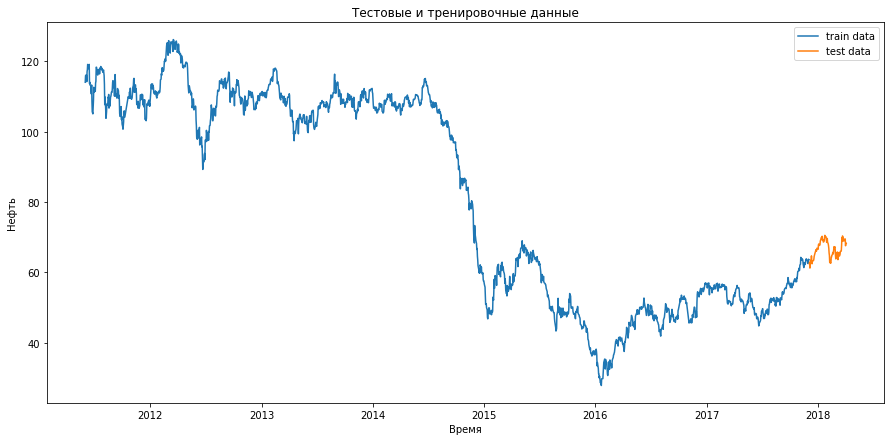

In [55]:
train, test = split_data( brent_data[-2000:], -100)

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Нефть')
plt.plot(train.index,train.iloc[:,0], label='train data' )
plt.plot(test.index,test.iloc[:,0], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [56]:
X_train =X_new[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_new[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]
train.shape

(1900, 18)

In [57]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

In [58]:
model_g = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model_l = LinearRegression()

In [59]:
model_l.fit( X_train, y_train ) # 
model_g.fit( X_train, y_train ) 

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=15,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [60]:
X_test.shape

(328, 5)

In [61]:
y_test_pred_g = model_g.predict(X_test)
y_test_pred_l= model_l.predict(X_test)

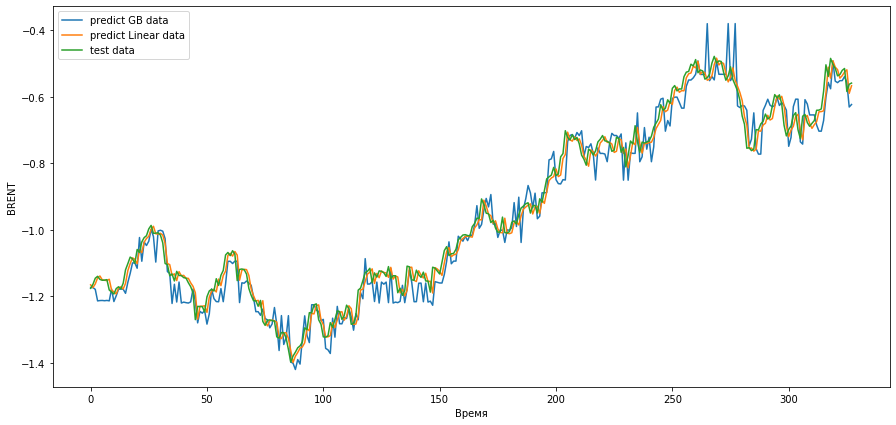

In [62]:
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('BRENT')
plt.plot(y_test_pred_g, label='predict GB data' )
plt.plot(y_test_pred_l, label='predict Linear data' )
plt.plot(y_test, label='test data')

plt.legend()
plt.show()

In [63]:
y_pred_g = model_g.predict(X_train)
y_pred_l= model_l.predict(X_train)

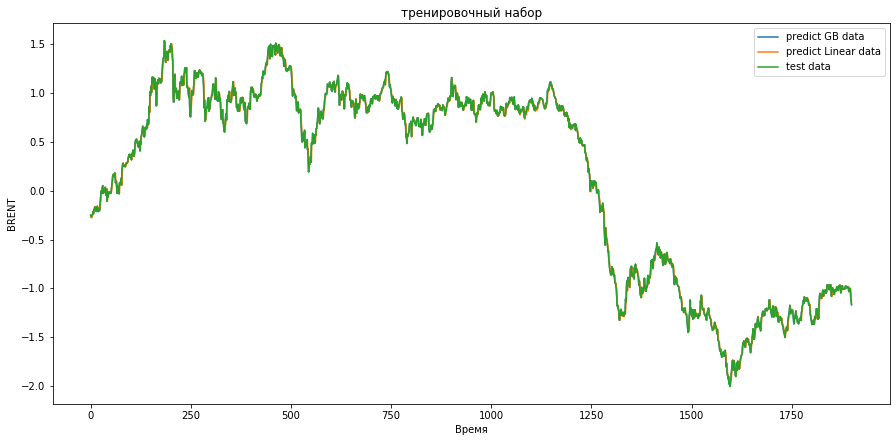

In [64]:
plt.figure( figsize=( 15, 7 ))

plt.title('тренировочный набор')
plt.xlabel('Время')
plt.ylabel('BRENT')
plt.plot(y_pred_g, label='predict GB data' )
plt.plot(y_pred_l, label='predict Linear data' )
plt.plot(y_train, label='test data')

plt.legend()
plt.show()

In [65]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [66]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   0.0025463701490121213 
ошибка mae  :   0.04018391541683226 
оценка R2 :   0.9618726285583667


In [67]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [68]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   1.9630753025503864 %


In [69]:
from sklearn.model_selection import RandomizedSearchCV

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

param_dist = {"max_depth": [3, 2,1,4,5], 
              "n_estimators":[100,200,300,400,500]}

#  randomized search
n_iter_search = 10

model_gr =GradientBoostingRegressor()

random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search, cv=5, iid=False)

random_search.fit(X_train, y_train)

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.860 (std: 0.164)
Parameters: {'n_estimators': 400, 'max_depth': 1}

Model with rank: 2
Mean validation score: 0.858 (std: 0.166)
Parameters: {'n_estimators': 300, 'max_depth': 1}

Model with rank: 3
Mean validation score: 0.855 (std: 0.170)
Parameters: {'n_estimators': 200, 'max_depth': 1}



In [70]:
model_g_best = GradientBoostingRegressor(max_depth=3,  n_estimators=300)
model_g_best.fit( X_train, y_train ) 
y_test_pred_g = model_g_best.predict(X_test)

er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   1.1529962803901637 %


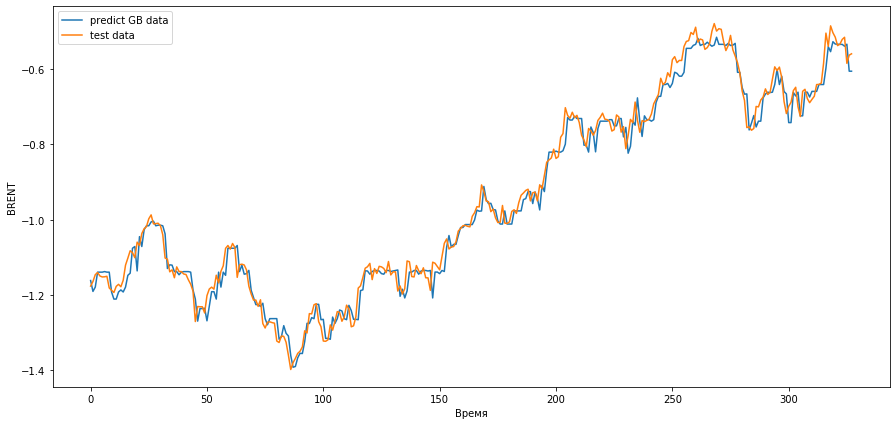

In [71]:
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('BRENT')
plt.plot(y_test_pred_g, label='predict GB data' )
plt.plot(y_test, label='test data')

plt.legend()
plt.show()

In [72]:
import pickle
# save the model to disk
filename = 'final_model_brent.sav'
pickle.dump(model_g_best, open(filename, 'wb'))

filename = 'final_scaler_brent_y.sav'
pickle.dump(scl_target, open(filename, 'wb'))

filename = 'final_scaler_brent_x.sav'
pickle.dump(scl_x, open(filename, 'wb'))

# Cделайте ее перрасчет (ресемплинг) в представление по неделям.

In [73]:
brent_data

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,t4,t3,t2,d4,d3,d2,doll
Дата,,,,,,,,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0,0,0,0,0,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0,0,0,0,0,0,0,30
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0,0,0,0,0,0,0,30
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0,0,0,0,0,0,0,30
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0,0,0,0,0,0,0,30
2010-09-06,76.87,2010,9,6,3,249,36,0,1,0,0,76,76,76,0,0,0,30
2010-09-07,77.26,2010,9,7,3,250,36,1,0,0,1,76,76,76,0,0,0,30
2010-09-08,77.93,2010,9,8,3,251,36,2,0,0,0,76,76,76,0,0,0,30
2010-09-09,77.21,2010,9,9,3,252,36,3,0,0,0,76,76,77,0,0,0,30


In [74]:
brent_data.isnull()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,t4,t3,t2,d4,d3,d2,doll
Дата,,,,,,,,,,,,,,,,,,
2010-09-01,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2010-09-02,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2010-09-03,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2010-09-04,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2010-09-05,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2010-09-06,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2010-09-07,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2010-09-08,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2010-09-09,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [75]:
# Для начала произведём ресемплинг brent_data на недельный масштаб
w_brent_data=brent_data.copy()
w_brent_data = w_brent_data.resample("W").apply('mean')
w_brent_data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,t4,t3,t2,d4,d3,d2,doll
Дата,,,,,,,,,,,,,,,,,,
2010-09-05,76.616000,2010.0,9.000000,3.000000,3.000000,246.000000,35.0,4.000000,0.000000,0.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000
2010-09-12,77.673333,2010.0,9.000000,8.500000,3.000000,251.500000,36.0,2.500000,0.166667,0.0,0.166667,76.166667,76.333333,76.500000,0.166667,0.166667,0.166667,30.000000
2010-09-19,78.693333,2010.0,9.000000,15.666667,3.000000,258.666667,37.0,2.666667,0.000000,0.0,0.000000,78.000000,78.333333,78.500000,0.000000,0.000000,0.000000,30.500000
2010-09-26,78.518333,2010.0,9.000000,22.666667,3.000000,265.666667,38.0,2.666667,0.000000,0.0,0.000000,78.166667,77.833333,77.666667,0.000000,0.000000,0.000000,30.166667
2010-10-03,81.211667,2010.0,9.333333,19.666667,3.333333,272.666667,39.0,2.666667,0.000000,0.0,0.000000,77.666667,78.166667,79.000000,0.500000,0.500000,0.500000,29.666667


In [76]:
w_brent_data.isnull()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,t4,t3,t2,d4,d3,d2,doll
Дата,,,,,,,,,,,,,,,,,,
2010-09-05,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2010-09-12,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2010-09-19,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2010-09-26,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2010-10-03,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2010-10-10,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2010-10-17,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2010-10-24,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2010-10-31,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


## Обрабатываю индекс rub_doll

In [77]:
# На данный момент resample не хочет работать с данным индексом т.к. не смотря на его похожесть на datetime, 
# это просто набор текста. Resample жалуется указывая на сей недостаток датасета и не хочет дальше работать.
# Поэтому для продолжения, нам необходимо превратить rub_doll.index в datetime
rub_doll.index = pd.to_datetime(rub_doll.index)
# Вот теперь то мы можем спокойно и без ошибок провести ресемплинг индекса
w_rub_doll = rub_doll.resample("W", axis=0).apply('mean')
w_rub_doll.head()

,curs
2010-09-05,30.76125
2010-09-12,30.79402
2010-09-19,30.84672
2010-09-26,30.99920
2010-10-03,30.52764


## Обрабатываю индекс rub_e

In [78]:
# Всё таки прямо абсолютно идентично с rub_doll, только с rub_e
rub_e.index = pd.to_datetime(rub_e.index)
w_rub_e = rub_e.resample("W", axis=0).apply('mean')
w_rub_e.head()

,curs
2010-09-05,39.204675
2010-09-12,39.293360
2010-09-19,39.977740
2010-09-26,41.042640
2010-10-03,41.351660


# Постройте модель предсказания 1-й точки от текущей (h=1).

    Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

In [79]:
# brent_data = w_brent_data

In [132]:
scl_target=StandardScaler() 

h=1
target = w_brent_data["Значение"].values[h:].reshape((w_brent_data.shape[0]-h,1))
y = scl_target.fit_transform(target)
y.shape
y[np.isnan(y)] = 0 #Перезаписываю все NaN на нолики :3

In [136]:
scl_x=StandardScaler() 

X = w_brent_data.iloc[:-1,:].values
X[np.isnan(X)] = 0 #Перезаписываю все NaN на нолики :3

In [137]:
X = scl_x.fit_transform(X.astype('float64'))
X.shape

(396, 18)

In [138]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import f_regression, mutual_info_regression

f_test, _ = f_regression(X, y.ravel())

for i in range(X.shape[1]):
    print("F-test={:.2f},  I={}".format(f_test[i],i))

F-test=4864.08,  I=0
F-test=1.64,  I=1
F-test=0.83,  I=2
F-test=0.09,  I=3
F-test=0.86,  I=4
F-test=0.78,  I=5
F-test=0.75,  I=6
F-test=87.95,  I=7
F-test=0.29,  I=8
F-test=0.08,  I=9
F-test=0.08,  I=10
F-test=3644.13,  I=11
F-test=3723.62,  I=12
F-test=3800.46,  I=13
F-test=0.64,  I=14
F-test=0.64,  I=15
F-test=0.64,  I=16
F-test=596.91,  I=17


Проверка F-test показывает интересные признаки 7, 11, 12, 13, 17

In [139]:
sfk =SelectKBest(f_regression, k=5)
X_new1 =sfk.fit_transform(X, y.ravel())
X_new1.shape

(396, 5)

In [140]:
sfp=SelectPercentile(f_regression, percentile=10)
X_new2 = sfp.fit_transform(X, y.ravel())
X_new2.shape

(396, 2)

In [141]:
gr_model = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100).fit(X, y.ravel())
sfm = SelectFromModel(gr_model,  max_features = 5)

sfm.fit(X, y.ravel())
X_new3 = sfm.transform(X)
X_new3.shape

(396, 1)

In [142]:
[X_new1[:5,:], X_new2[:5,:],X_new3[:5,:]]

[array([[-0.21130413, -2.83720584, -2.83686496, -2.83675848, -1.49739432],
        [-0.17433788, -0.20105711, -0.19527205, -0.18952716, -1.12031871],
        [-0.13867688, -0.13760495, -0.12606   , -0.1203185 , -1.08889575],
        [-0.14479519, -0.13183657, -0.14336301, -0.14915544, -1.10984439],
        [-0.05063148, -0.1491417 , -0.13182767, -0.10301634, -1.14126736]]),
 array([[-0.21130413, -2.83675848],
        [-0.17433788, -0.18952716],
        [-0.13867688, -0.1203185 ],
        [-0.14479519, -0.14915544],
        [-0.05063148, -0.10301634]]),
 array([[-0.21130413],
        [-0.17433788],
        [-0.13867688],
        [-0.14479519],
        [-0.05063148]])]

In [143]:
list_param_k =np.where(sfk.get_support())[0]
list_param_p =np.where(sfp.get_support())[0]
list_param_m =np.where(sfm.get_support())[0]

print('Номера признаков k лучших признаков : ',list_param_k)
print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
print('Номера признаков для выбора по модели : ',list_param_m)

Номера признаков k лучших признаков :  [ 0 11 12 13 17]
Номера признаков лучших признаков по процентной форме:  [ 0 13]
Номера признаков для выбора по модели :  [0]


In [144]:
X_new = X[:,[0,11,12,13,17]]

In [145]:
# сделаем функцию
def split_data( data, split_date ):
    return data.iloc[:split_date,:].copy(), \
           data.iloc[split_date:,:].copy()

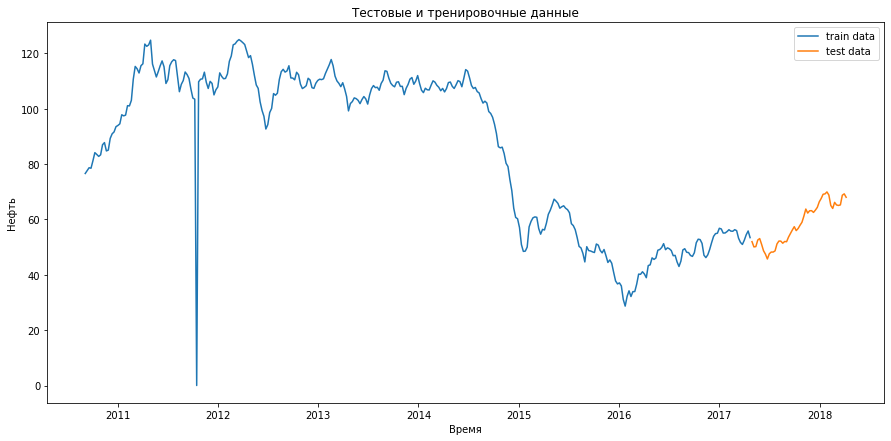

In [160]:
train, test = split_data( w_brent_data[-2000:], -50)

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Нефть')
plt.plot(train.index,train.iloc[:,0], label='train data' )
plt.plot(test.index,test.iloc[:,0], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [161]:
X_train =X_new[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_new[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]

In [162]:
train.shape

(347, 18)

In [163]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

In [164]:
model_g = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model_l = LinearRegression()

In [165]:
model_l.fit( X_train, y_train ) # 
model_g.fit( X_train, y_train ) 

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=15,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [166]:
X_test.shape

(49, 5)

In [167]:
y_test_pred_g = model_g.predict(X_test)
y_test_pred_l= model_l.predict(X_test)

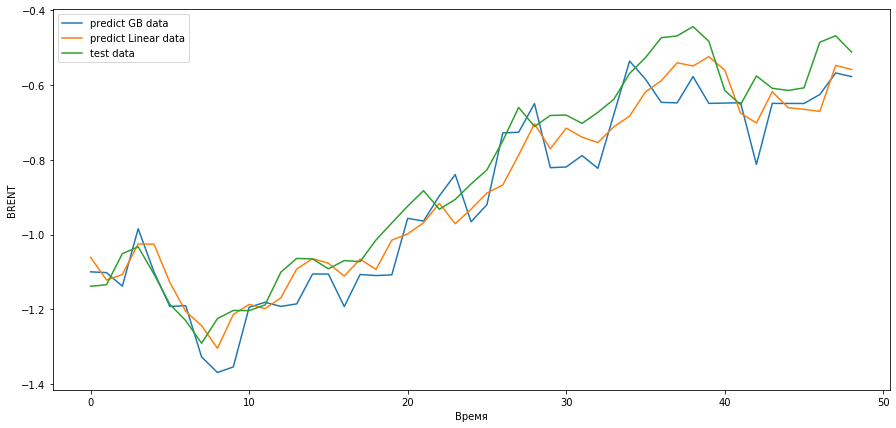

In [168]:
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('BRENT')
plt.plot(y_test_pred_g, label='predict GB data' )
plt.plot(y_test_pred_l, label='predict Linear data' )
plt.plot(y_test, label='test data')

plt.legend()
plt.show()

In [171]:
y_pred_g = model_g.predict(X_train)
y_pred_l= model_l.predict(X_train)
#хитро

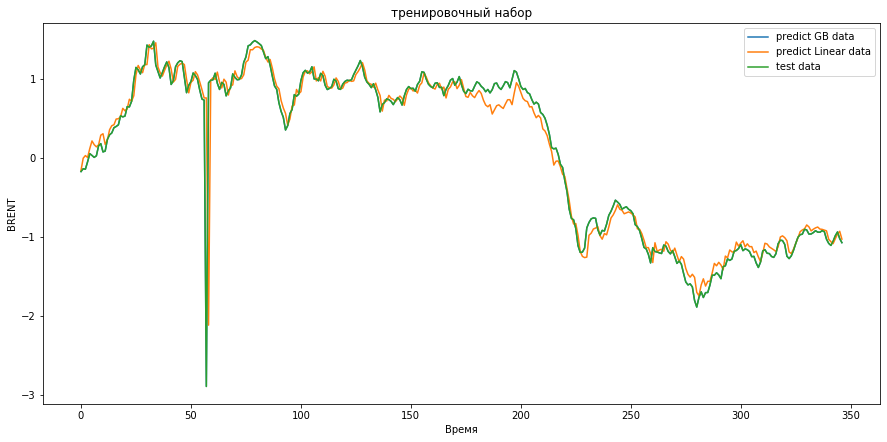

In [174]:
plt.figure( figsize=( 15, 7 ))

plt.title('тренировочный набор')
plt.xlabel('Время')
plt.ylabel('BRENT')
plt.plot(y_pred_g, label='predict GB data' )
plt.plot(y_pred_l, label='predict Linear data' )
plt.plot(y_train, label='test data')

plt.legend()
plt.show()

In [173]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [175]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   0.009135787529675537 
ошибка mae  :   0.077961408953336 
оценка R2 :   0.8665762915891715


In [176]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [177]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   3.7549723962293933 %


In [178]:
from sklearn.model_selection import RandomizedSearchCV

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

param_dist = {"max_depth": [3, 2,1,4,5], 
              "n_estimators":[100,200,300,400,500]}

#  randomized search
n_iter_search = 10

model_gr =GradientBoostingRegressor()

random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search, cv=5, iid=False)

random_search.fit(X_train, y_train)

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.064 (std: 0.967)
Parameters: {'n_estimators': 200, 'max_depth': 1}

Model with rank: 2
Mean validation score: 0.043 (std: 0.901)
Parameters: {'n_estimators': 100, 'max_depth': 1}

Model with rank: 3
Mean validation score: 0.012 (std: 1.068)
Parameters: {'n_estimators': 300, 'max_depth': 1}



In [179]:
model_g_best = GradientBoostingRegressor(max_depth=3,  n_estimators=300)
model_g_best.fit( X_train, y_train ) 
y_test_pred_g = model_g_best.predict(X_test)

er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   3.066743054191278 %


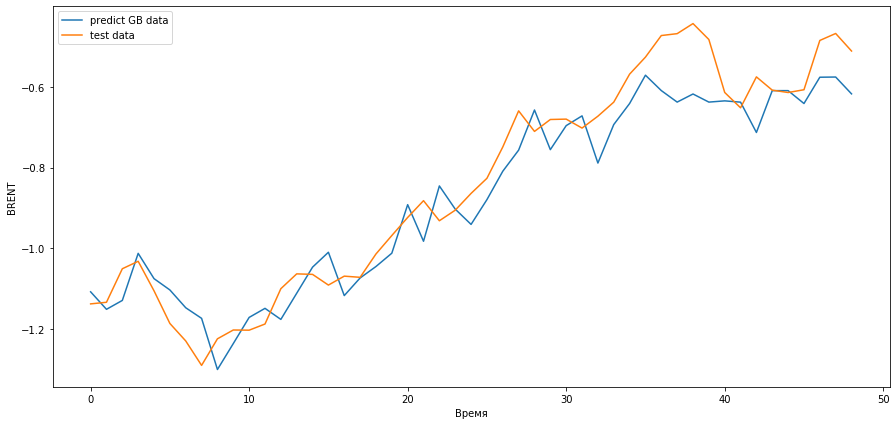

In [180]:
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('BRENT')
plt.plot(y_test_pred_g, label='predict GB data' )
plt.plot(y_test, label='test data')

plt.legend()
plt.show()